Enter the stock ticker symbol: AMZN
Calls - SVR MSE: 702.268, MAE: 19.464, RMSE: 26.500
Calls - Random Forest MSE: 6.140, MAE: 1.514, RMSE: 2.478


/var/folders/jw/f0mq7jf142x_bfn4pt40fh780000gn/T/ipykernel_76485/2754728442.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return hist['Close'][-1]


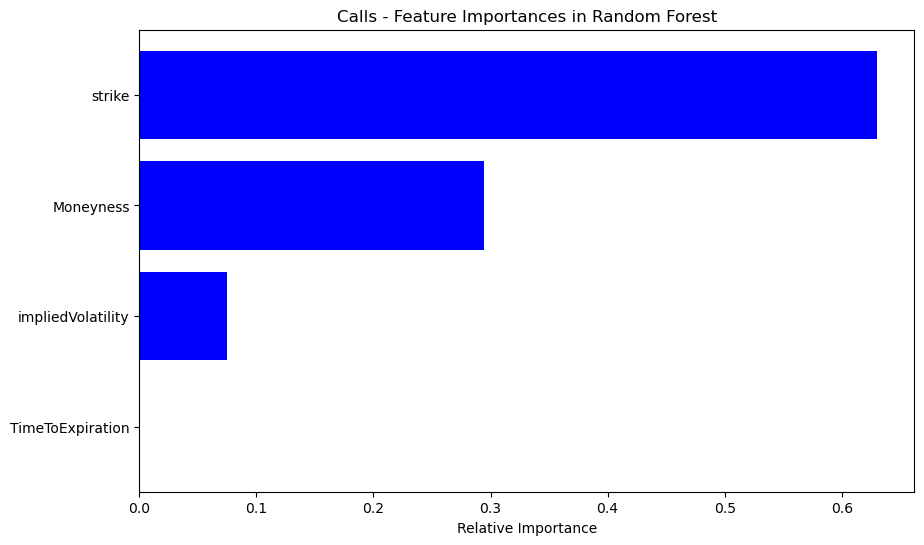

Calls - XGBoost MSE: 11.146, MAE: 2.171, RMSE: 3.339


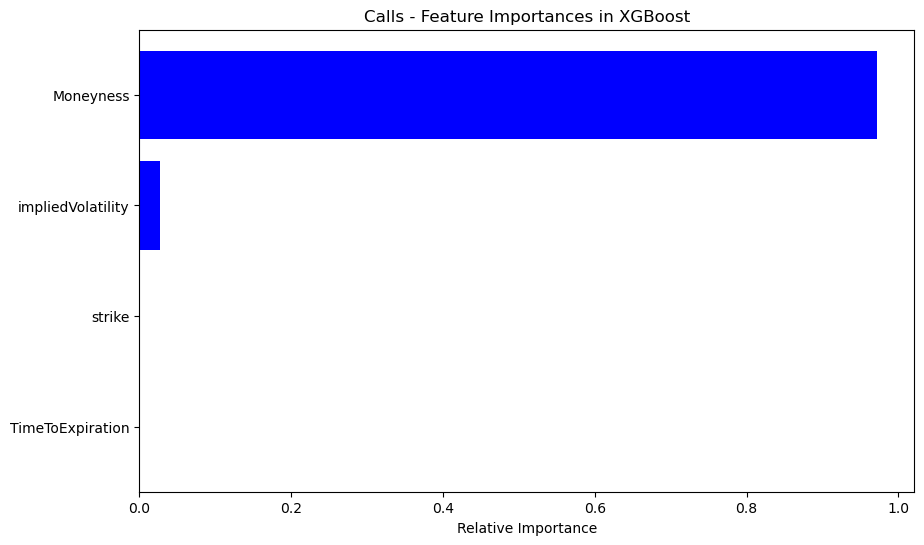

Calls - LightGBM MSE: 227.586, MAE: 8.462, RMSE: 15.086


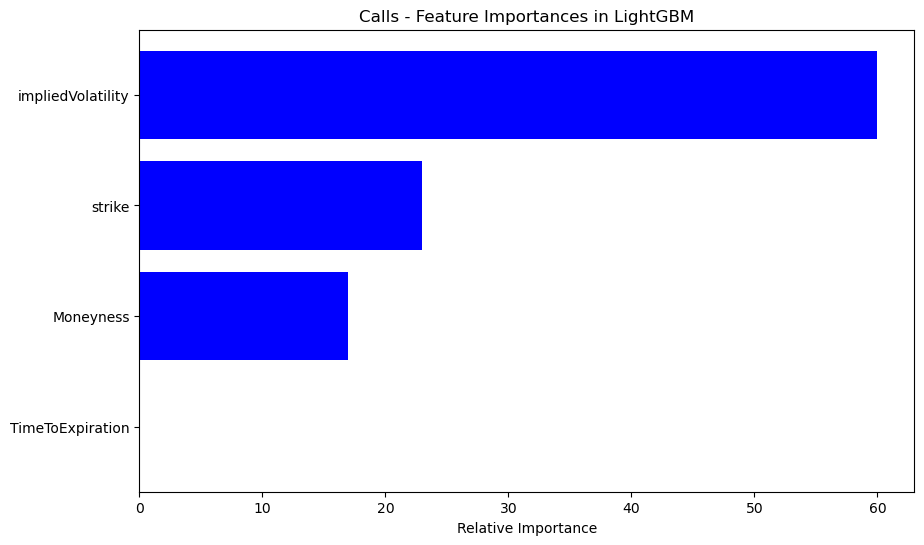

Puts - SVR MSE: 277.102, MAE: 7.708, RMSE: 16.646
Puts - Random Forest MSE: 4.119, MAE: 0.773, RMSE: 2.029


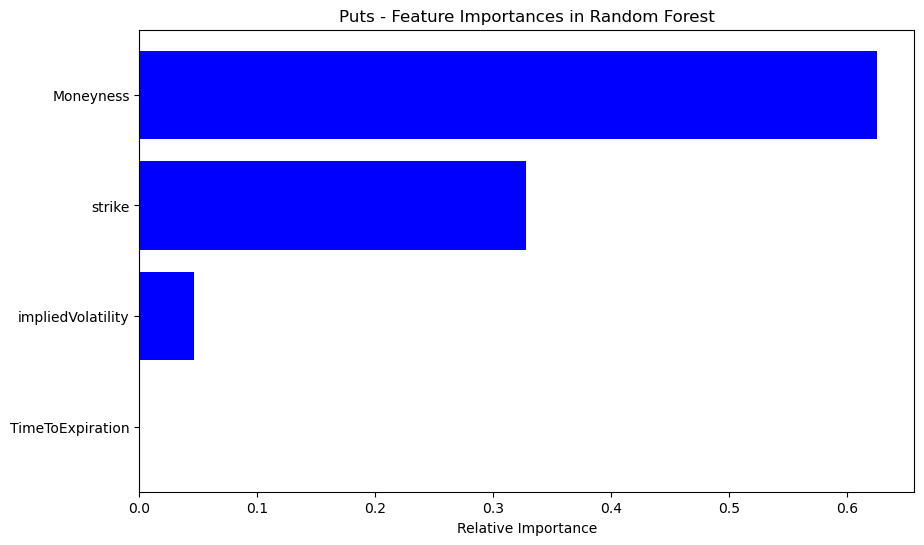

Puts - XGBoost MSE: 5.653, MAE: 0.909, RMSE: 2.378


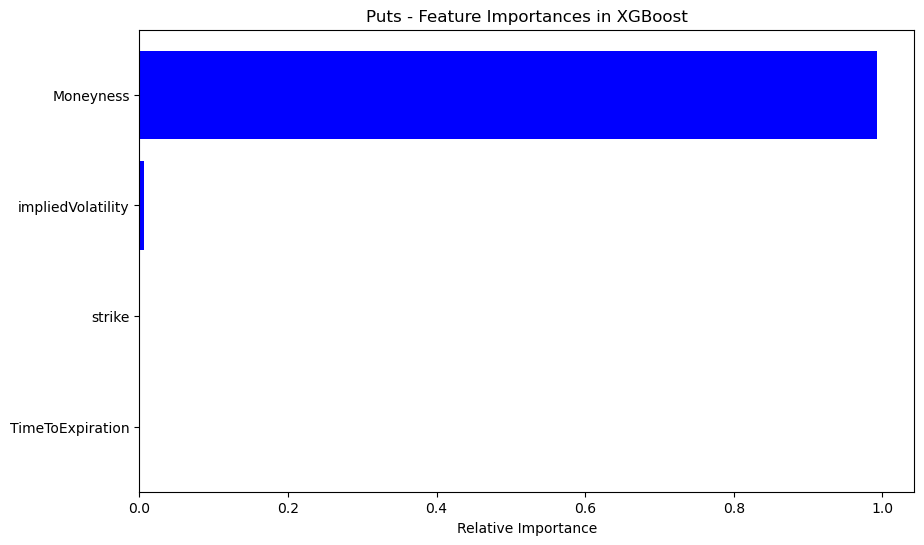

Puts - LightGBM MSE: 52.357, MAE: 5.977, RMSE: 7.236


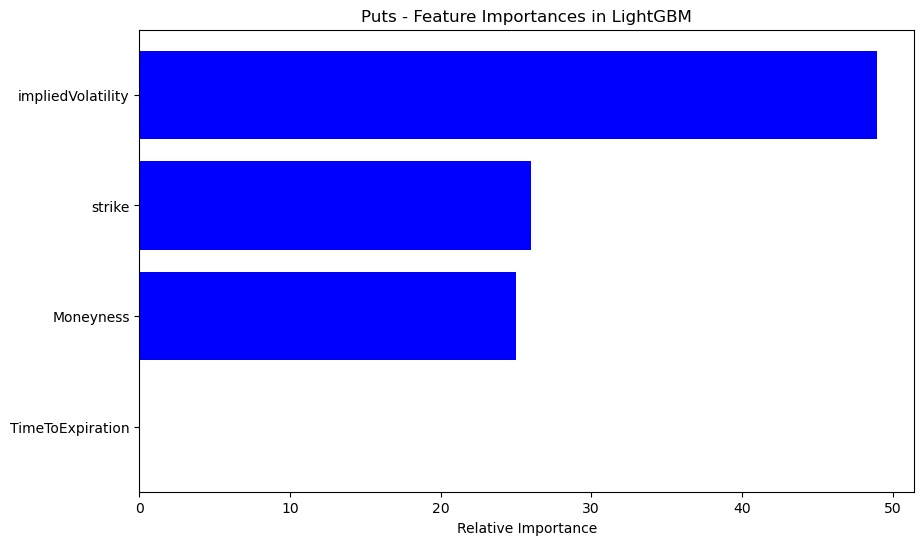

/var/folders/jw/f0mq7jf142x_bfn4pt40fh780000gn/T/ipykernel_76485/2754728442.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return hist['Close'][-1]


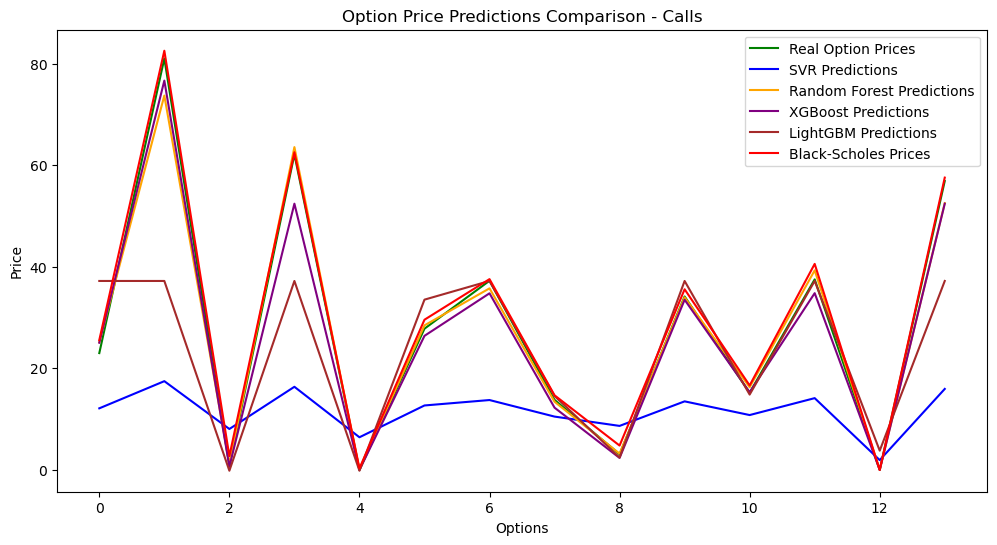

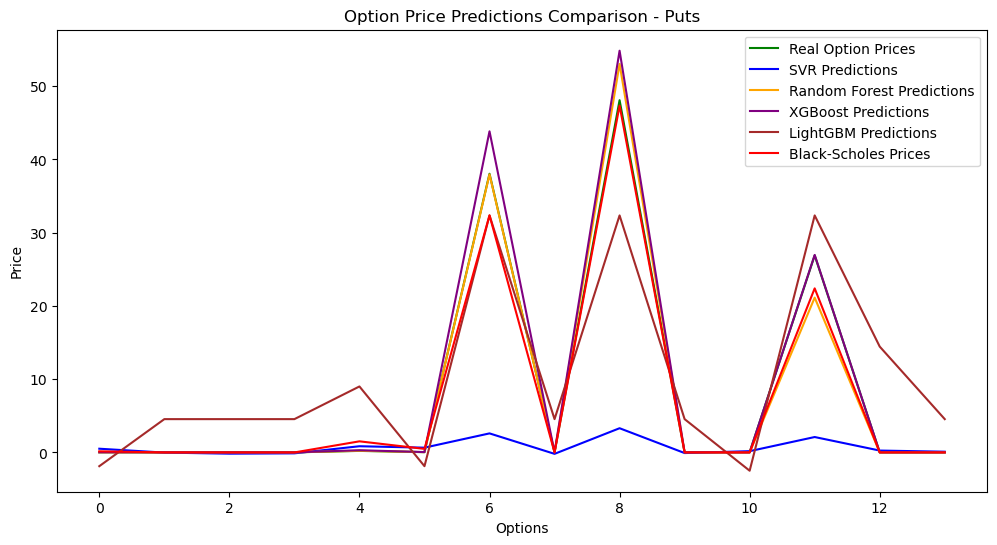

Black-Scholes Model (Calls) - MSE: 2.394, MAE: 1.284, RMSE: 1.547
Black-Scholes Model (Puts) - MSE: 3.925, MAE: 0.920, RMSE: 1.981


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import norm

# Function to calculate Black-Scholes option price
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price
    
# Additional function for feature engineering
def feature_engineering(options_data, current_price, expiration_date):
    options_data['Moneyness'] = current_price / options_data['strike']
    options_data['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days
    return options_data

# Function to fetch the current stock price
def fetch_current_stock_price(ticker):
    hist = ticker.history(period="1d")
    return hist['Close'][-1]

# Modified function to fetch both call and put options data
def fetch_options_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    exp_dates = ticker.options
    if not exp_dates:
        return None, None, None
    expiration_date = exp_dates[0]
    options_data = ticker.option_chain(expiration_date)
    return options_data.calls, options_data.puts, expiration_date

# User input for stock symbol
stock_symbol = input("Enter the stock ticker symbol: ")

# Fetching data
ticker = yf.Ticker(stock_symbol)
calls_data, puts_data, expiration_date = fetch_options_data(stock_symbol)
current_price = fetch_current_stock_price(ticker)

# Feature engineering for both calls and puts
calls_data = feature_engineering(calls_data, current_price, expiration_date)
puts_data = feature_engineering(puts_data, current_price, expiration_date)

# Preparing data for models
def prepare_data(options_data):
    X = options_data[['Moneyness', 'TimeToExpiration', 'impliedVolatility','strike']]
    y = options_data['lastPrice']
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train_calls, X_test_calls, y_train_calls, y_test_calls = prepare_data(calls_data)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = prepare_data(puts_data)

# Models
models = {
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

# Modified function to train, predict, evaluate, and return predictions
def train_predict_evaluate_plot(models, X_train, X_test, y_train, y_test, option_type):
    model_predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        model_predictions[name] = predictions
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mse)
        print(f"{option_type} - {name} MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")

        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            importances = model.feature_importances_
            indices = np.argsort(importances)
            plt.title(f'{option_type} - Feature Importances in {name}')
            plt.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()
    return model_predictions

# Get model predictions for calls and puts
option_price_predictions_calls = train_predict_evaluate_plot(models, X_train_calls, X_test_calls, y_train_calls, y_test_calls, "Calls")
option_price_predictions_puts = train_predict_evaluate_plot(models, X_train_puts, X_test_puts, y_train_puts, y_test_puts, "Puts")

# Function for calculating Black-Scholes prices
def calculate_bs_prices(test_data, current_price, T, r, sigma, option_type='call'):
    bs_prices = []
    for index, row in test_data.iterrows():
        K = row['strike']
        bs_price = black_scholes(current_price, K, T, r, sigma, option_type)
        bs_prices.append(bs_price)
    return bs_prices

# Fetching the current stock price and assigning it to the variable 'current_stock_price'
current_stock_price = fetch_current_stock_price(ticker)

T = 30 / 365  # Time to expiration in years
r = 0.01  # Risk-free interest rate
sigma = 0.2  # Volatility

# Calculate Black-Scholes prices for calls and puts
bs_prices_calls = calculate_bs_prices(X_test_calls, current_stock_price, T, r, sigma, 'call')
bs_prices_puts = calculate_bs_prices(X_test_puts, current_stock_price, T, r, sigma, 'put')

# Function to plot comparisons
def plot_comparison(test_y, predictions_dict, bs_prices, title):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(test_y)), test_y, label='Real Option Prices', color='green')

    colors = ['blue', 'orange', 'purple', 'brown']
    for (model_name, predictions), color in zip(predictions_dict.items(), colors):
        plt.plot(range(len(predictions)), predictions, label=f'{model_name} Predictions', color=color)

    plt.plot(range(len(bs_prices)), bs_prices, label='Black-Scholes Prices', color='red')
    plt.title(title)
    plt.xlabel('Options')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plotting comparison for Calls and Puts
plot_comparison(y_test_calls, option_price_predictions_calls, bs_prices_calls, 'Option Price Predictions Comparison - Calls')
plot_comparison(y_test_puts, option_price_predictions_puts, bs_prices_puts, 'Option Price Predictions Comparison - Puts')

# Calculate MSE, MAE, and RMSE for Black-Scholes model (Calls)
mse_bs_calls = mean_squared_error(y_test_calls, bs_prices_calls)
mae_bs_calls = mean_absolute_error(y_test_calls, bs_prices_calls)
rmse_bs_calls = np.sqrt(mse_bs_calls)

# Calculate MSE, MAE, and RMSE for Black-Scholes model (Puts)
mse_bs_puts = mean_squared_error(y_test_puts, bs_prices_puts)
mae_bs_puts = mean_absolute_error(y_test_puts, bs_prices_puts)
rmse_bs_puts = np.sqrt(mse_bs_puts)

print(f"Black-Scholes Model (Calls) - MSE: {mse_bs_calls:.3f}, MAE: {mae_bs_calls:.3f}, RMSE: {rmse_bs_calls:.3f}")
print(f"Black-Scholes Model (Puts) - MSE: {mse_bs_puts:.3f}, MAE: {mae_bs_puts:.3f}, RMSE: {rmse_bs_puts:.3f}")

In [4]:

print(f"Black-Scholes Model (Calls) - MSE: {mse_bs_calls:.3f}, MAE: {mae_bs_calls:.3f}, RMSE: {rmse_bs_calls:.3f}")
print(f"Black-Scholes Model (Puts) - MSE: {mse_bs_puts:.3f}, MAE: {mae_bs_puts:.3f}, RMSE: {rmse_bs_puts:.3f}")

Black-Scholes Model (Calls) - MSE: 1.969, MAE: 0.914, RMSE: 1.403
Black-Scholes Model (Puts) - MSE: 126.536, MAE: 6.748, RMSE: 11.249
